# Tensorflow Model One

## Steps:
1. Load/Import Dependencies
- Load Paths
- Create tensflow datasets
2. Create training(80%), testing(10%) and validating(10%)
3. Build / Define the Model
4. Train the Model
-  Save the History Callback Object
5. Evaluate Model
- Model Loss Graph
- Model Accuracy Graph
6.  Make and Evaluate New Predictions Using Our Testing Data
7. Confusion  Matrix
- Checking Our Scores
- Classification Report

In [1]:
# For Google Colab imports
!pip install fastparquet
!pip install tensorflow

# 1. Load/Import Dependencies

In [3]:
import tensorflow as tf  #Our model framework
import os # Working with files
import pandas as pd #To create/manipulate a dataframe
import numpy as np # Data wrangling.

# Evaluating Model
from sklearn.preprocessing import StandardScaler # To perform standardization by centering and scaling.
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score, multilabel_confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers                  # Keras layers API.
from tensorflow.keras.layers import Conv1D, Dense, Flatten # Conv2D is a convolution neural network. Flatten is to make everything into one dimensional
from tensorflow.keras.callbacks import EarlyStopping     # Stop training when a monitored metric has stopped improving.
from sklearn.model_selection import train_test_split # To split data in training/validating/testing.
from tensorflow.keras.callbacks import ReduceLROnPlateau # Reduce learning rate when a metric has stopped improving.
from tensorflow.keras.models import load_model           # To load the model.
import pickle # Python object serialization.

#  Visualise Model Performance
import seaborn as sns
sns.set()
# import plotly.express as px
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1.1 Loading data path

In [3]:
fake_features = os.path.join('/content/drive/MyDrive/Data/Features/fakefeatures.csv')
real_features = os.path.join('/content/drive/MyDrive/Data/Features/realfeatures.csv')

## 1.2 Making csv files dataframes

In [4]:
df_fake_features = pd.read_csv(fake_features)
df_real_features = pd.read_csv(real_features)

## 1.3 Checking Dataframe

In [5]:
def inspect_dataframe(input_df):

    print('The Null Values:\n',input_df.isnull().sum())
    print('\n')
    print('The Duplicate Values:\n',input_df.duplicated().sum())
    print('\n')
    print('The Description:\n',input_df.describe())
    print('\n')
    print('Columns:')
    for col in input_df.columns:
        print(col)

    pass

In [6]:
inspect_dataframe(df_fake_features)

The Null Values:
 melspectrogram        0
spectral_centroid     0
spectral_bandwidth    0
chroma_stft           0
zero_crossing_rate    0
rms                   0
chroma_cqt            0
chroma_cens           0
spectral_rolloff      0
dtype: int64


The Duplicate Values:
 0


The Description:
        melspectrogram  spectral_centroid  spectral_bandwidth  chroma_stft  \
count      500.000000         500.000000          500.000000   500.000000   
mean         0.538046        1488.692597         1337.144341     0.353455   
std          0.575525         342.685071          242.453152     0.045300   
min          0.006590         645.224357          737.956602     0.227775   
25%          0.196403        1256.266363         1170.852540     0.324837   
50%          0.360922        1468.679929         1327.755327     0.358588   
75%          0.630643        1716.815717         1492.099109     0.385389   
max          3.766791        2639.623920         2116.693907     0.497866   

       zero_

In [7]:
df_fake_features['label'] = 0
df_fake_features['label_name'] = 'fake'
df_real_features['label'] = 1
df_real_features['label_name'] = 'real'
df_features_combined = pd.concat([df_fake_features, df_real_features], ignore_index=True)
df_features_combined


,melspectrogram,spectral_centroid,spectral_bandwidth,chroma_stft,zero_crossing_rate,rms,chroma_cqt,chroma_cens,spectral_rolloff,label,label_name
0,0.501412,1573.542866,1436.049412,0.373341,0.433252,0.249936,2950.458829,0.093928,0.093928,0,fake
1,0.467492,1475.354777,1331.141484,0.367566,0.448620,0.260989,2638.118004,0.130189,0.130189,0,fake
2,0.360517,1803.124445,1334.663490,0.363125,0.474792,0.268324,3043.204698,0.178695,0.178695,0,fake
3,0.512352,1507.417621,1313.102750,0.334021,0.418174,0.263614,2730.338542,0.135864,0.135864,0,fake
4,0.546540,1595.520466,1288.440156,0.341906,0.443642,0.257819,2823.807566,0.182823,0.182823,0,fake
...,...,...,...,...,...,...,...,...,...,...,...
995,2.071994,2030.263536,1765.157588,0.277827,0.401236,0.254103,4023.215869,0.130873,0.130873,1,real
996,2.750954,873.896082,967.743441,0.327787,0.416305,0.244682,1689.837598,0.061589,0.061589,1,real
997,0.667455,1454.454083,1386.370428,0.313234,0.407361,0.259663,2771.294643,0.105313,0.105313,1,real
998,4.263884,1212.201879,1384.560414,0.319400,0.434800,0.271321,2354.705991,0.081373,0.081373,1,real


In [8]:
fake_real_audio = sorted(df_features_combined['label_name'].unique())
print(fake_real_audio)

['fake', 'real']


# 2. Create training, testing and validating

## 2.1 Split Our Data Into Three Sets:
> 1. Training   (80%)
> 2. Validating (10%)
> 3. Testing    (10%)

In [1]:
real = 1000
fake = 1000
batchsize = round((real + fake) * 0.02)
print("batchsize: ",batchsize)
prefetech = round(batchsize / 2)
print("prefetech: ",prefetech)

batchsize:  40
prefetech:  20


In [10]:
X = df_features_combined.drop(labels=['label', 'label_name'], axis=1)
y = df_features_combined['label']


In [11]:
X_train, X_remain, y_train, y_remain = train_test_split(
    X, y, test_size = 0.2, random_state = 42)

print('X_remain.shape = ', X_remain.shape)
print('y_remain.shape = ', y_remain.shape)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_remain, y_remain, test_size = 0.5, random_state = 42)

print('X_train.shape  = ', X_train.shape)
print('y_train.shape  = ', y_train.shape)
print('X_valid.shape  = ', X_valid.shape)
print('y_valid.shape  = ', y_valid.shape)
print('X_test.shape   = ', X_test.shape)
print('y_test.shape   = ', y_test.shape)

X_remain.shape =  (200, 9)
y_remain.shape =  (200,)
X_train.shape  =  (800, 9)
y_train.shape  =  (800,)
X_valid.shape  =  (100, 9)
y_valid.shape  =  (100,)
X_test.shape   =  (100, 9)
y_test.shape   =  (100,)


In [12]:
# Standardize / Scale data.
# Standardize features by removing the mean and scaling to unit variance.
# z = (x - u) / s

standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train.values)
X_valid = standard_scaler.transform(X_valid.values)
X_test = standard_scaler.transform(X_test.values)

print('X_train.shape  = ', X_train.shape)
print('X_remain.shape = ', X_remain.shape)
print('X_valid.shape  = ', X_valid.shape)
print('X_test.shape   = ', X_test.shape)


X_train.shape  =  (800, 9)
X_remain.shape =  (200, 9)
X_valid.shape  =  (100, 9)
X_test.shape   =  (100, 9)


In [13]:
# Modify data to fit into a 1D-CNN.

X_train = np.expand_dims(X_train, axis = 2)
X_valid = np.expand_dims(X_valid, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)

print('X_train.shape  = ', X_train.shape)
print('X_remain.shape = ', X_remain.shape)
print('X_valid.shape  = ', X_valid.shape)
print('X_test.shape   = ', X_test.shape)

X_train.shape  =  (800, 9, 1)
X_remain.shape =  (200, 9)
X_valid.shape  =  (100, 9, 1)
X_test.shape   =  (100, 9, 1)


# 3. Build / Define the Model

In [14]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 10,
                               mode = 'auto',
                               restore_best_weights = True)

In [15]:
reduce_learning_rate = ReduceLROnPlateau(monitor ='val_accuracy',
                                         factor = 0.5,
                                         verbose = 1,
                                         min_lr = 0.00001)

In [16]:
# Create Neural Network

model = Sequential()
model.add(layers.Conv1D(filters = 32, kernel_size = 5, strides = 5, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5,strides = 3, padding='same'))

model.add(layers.Conv1D(filters = 32, kernel_size = 5, strides = 5,padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5,strides = 3, padding='same'))

model.add(layers.Conv1D(filters = 16, kernel_size = 5, strides = 5,padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5,strides = 3, padding='same'))

model.add(layers.Conv1D(filters = 16, kernel_size = 5, strides = 5,padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5,strides = 3, padding='same'))

model.add(layers.Conv1D(filters = 8, kernel_size = 5, strides = 5,padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5,strides = 3, padding='same'))

model.add(layers.Conv1D(filters = 8, kernel_size = 5, strides = 5,padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5,strides = 3, padding='same'))


model.add(layers.Flatten())

model.add(layers.Dense(32, activation='relu'))

model.add(layers.BatchNormalization())

model.add(layers.Dense(1, activation='sigmoid'))

model.compile('Adam', loss='BinaryCrossentropy', metrics=['accuracy'])

# 4. Train the Model

In [17]:
history_callback_object = model.fit(
    x = X_train, y = tf.cast(y_train, tf.float32), batch_size = 20,
    epochs = 100, verbose = 1,
    shuffle = True,
    callbacks = [early_stopping, reduce_learning_rate],
    validation_data = ( X_valid, tf.cast(y_valid, tf.float32) ))

Epoch 1/100
40/40 [==============================] - 17s 55ms/step - loss: 0.7105 - accuracy: 0.5938 - val_loss: 0.7065 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 1s 28ms/step - loss: 0.6094 - accuracy: 0.6662 - val_loss: 0.7272 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 1s 27ms/step - loss: 0.5752 - accuracy: 0.7212 - val_loss: 0.7399 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 1s 27ms/step - loss: 0.5589 - accuracy: 0.7475 - val_loss: 0.7451 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 1s 20ms/step - loss: 0.5459 - accuracy: 0.7325 - val_loss: 0.7455 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 6/100
40/40 [==============================] - 1s 18ms/step - loss: 0.5053 - accuracy: 0.7588 - val_loss: 0.7407 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 7/100
40/40 [==============================] - 1s 18ms/step - l

## 4.1 To save history callback object

In [18]:
file_path_history_callback_object = '\content\drive\MyDrive\Data\Model'

with open(file_path_history_callback_object, 'wb') as history_callback_object_file:
    pickle.dump(history_callback_object.history, history_callback_object_file)

# This is used to load the history_callback_object whenever necessary.
# with open(file_path_history_callback_object, 'rb') as history_callback_object_file:
#     history_callback_object = pickle.load(history_callback_object_file)

In [19]:
file_path_model = '/content/drive/MyDrive/Data/Model/model.test'

model.save(file_path_model)

# 5. Evaluate Model

In [20]:
fig = px.line(data_frame = history_callback_object.history,
              y = ['loss', 'val_loss'],
              labels = {'index':'Epoch', 'value':'Loss'},
              title = 'Loss vs Epoch')
fig.show()

history_callback_object.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [21]:
fig = px.line(data_frame = history_callback_object.history,
              y = ['accuracy', 'val_accuracy'],
              labels = {'index':'Epoch', 'value':'Accuracy'},
              title = 'Accuracy vs Epoch')
fig.show()

history_callback_object.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

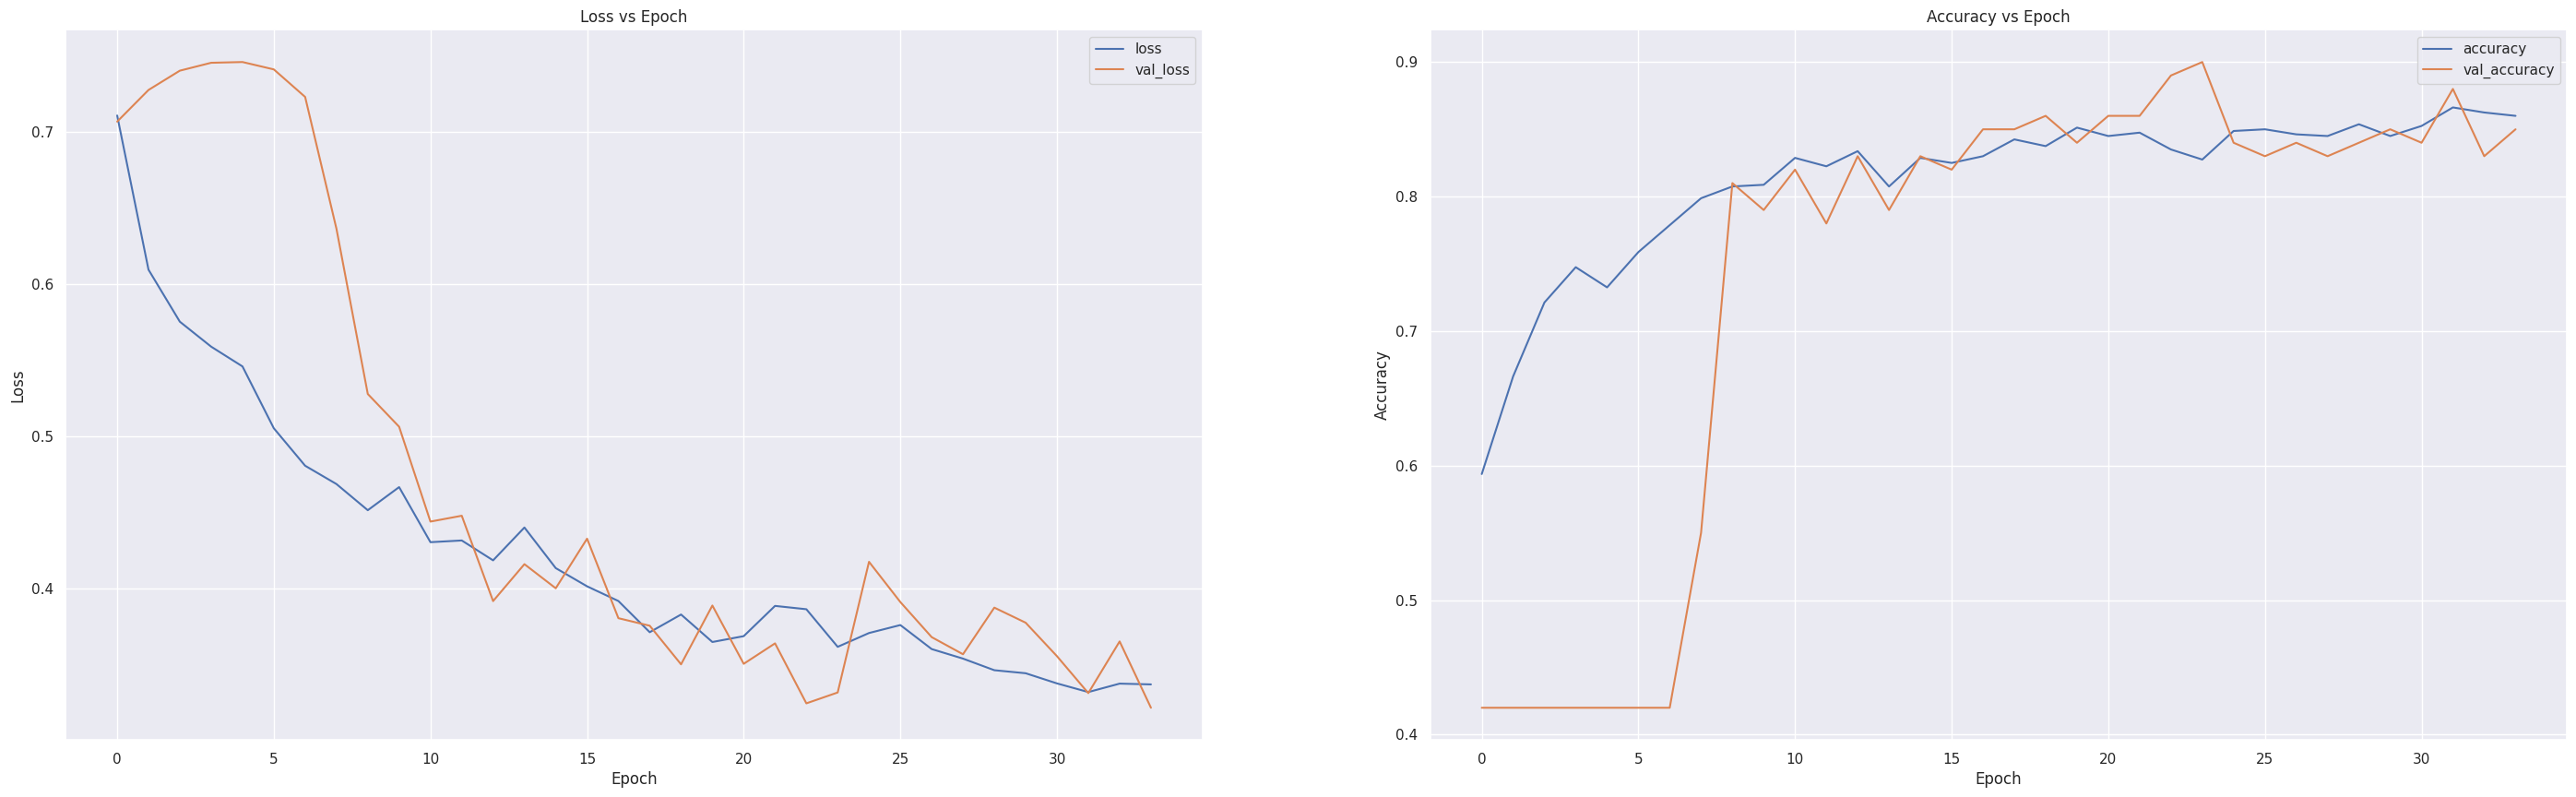

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history_callback_object.history['loss'], label = 'loss')
ax1.plot(history_callback_object.history['val_loss'], label = 'val_loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Epoch')
ax1.grid(True)

ax2.plot(history_callback_object.history['accuracy'], label = 'accuracy')
ax2.plot(history_callback_object.history['val_accuracy'], label = 'val_accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch')
ax2.grid(True)

fig.set_figheight(10)
fig.set_figwidth(35)
plt.show()

history_callback_object.history.keys()

# 6. Make and Evaluate New Predictions Using Our Testing Data

In [23]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true = y_test

y_pred = tf.round(y_pred)
y_pred = y_pred.numpy()

4/4 [==============================] - 1s 30ms/step


# 7. Confusion Matrix

      fake  real
fake    45     9
real     8    38 





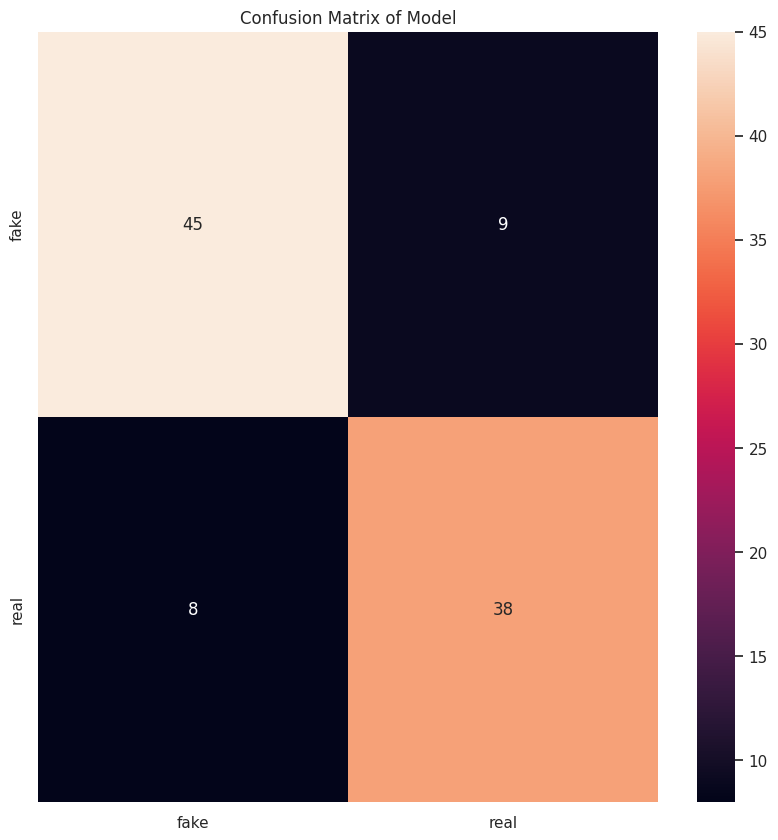

In [24]:
fig = plt.figure(figsize=(10, 10))
plt.title('Confusion Matrix of Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

model_matrix = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(model_matrix,
                  index = [i for i in fake_real_audio ],
                  columns = [i for i in fake_real_audio ]
                 )


ax = sns.heatmap(cm,
                 annot = True,
                 fmt = 'd',cbar=True)

print(cm, '\n\n\n')

plt.show()

## 7.1 Checking Our Scores

In [25]:
model_loss, model_accuracy = model.evaluate(X_test, y_test)

print('Model Test Loss: %f' % (model_loss))
print('Model Test Loss: %f' % (model_loss * 100), '%\n', sep = '')
print('Model Test Accuracy: %f' % (model_accuracy))
print('Model Test Accuracy: %f' % (model_accuracy * 100), '%', sep = '')

4/4 [==============================] - 1s 8ms/step - loss: 0.4100 - accuracy: 0.8300
Model Test Loss: 0.410003
Model Test Loss: 41.000286%

Model Test Accuracy: 0.830000
Model Test Accuracy: 82.999998%


In [26]:
# Calculate our accuracy score.
accuracy = accuracy_score(y_true, y_pred)

# Calculate our precision score.
precision = precision_score(y_true, y_pred, average = 'micro')

# Calculate our recall score.
recall = recall_score(y_true, y_pred, average = 'micro')

# Calculate our f1-score.
f1 = f1_score(y_true, y_pred, average = 'micro')

# Print each of our scores to inspect performance.
print('Accuracy Score: %f' % (accuracy * 100), '%', sep = '')
print('Precision Score: %f' % (precision * 100), '%', sep = '')
print('Recall Score: %f' % (recall * 100), '%', sep = '')
print('F1 Score: %f' % (f1 * 100), '%', sep = '')


Accuracy Score: 83.000000%
Precision Score: 83.000000%
Recall Score: 83.000000%
F1 Score: 83.000000%


## 7.2 Classification Report

In [27]:
print('Model Classification Report\n', classification_report(y_true, y_pred, target_names = fake_real_audio))

Model Classification Report
               precision    recall  f1-score   support

        fake       0.85      0.83      0.84        54
        real       0.81      0.83      0.82        46

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

